# Walkthrough notebook for the APPleSOSS (A Producer of ProfiLEs for SOSS) Module
Construct spatial profiles based on a given observed dataset for the first three SOSS orders to be used as the specprofile reference file in the ATOCA algorithm.

In [1]:
from astropy.io import fits,ascii
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sys import path
soss_path = '/Users/michaelradica/Documents/GitHub/jwst-mtl/'
soss_path = '/Users/albert/NIRISS/SOSSpipeline/jwst-mtl'
path.insert(1, soss_path)

from SOSS.dms.soss_centroids import get_soss_centroids
from SOSS.APPLESOSS.utils import replace_badpix
from SOSS.APPLESOSS import applesoss

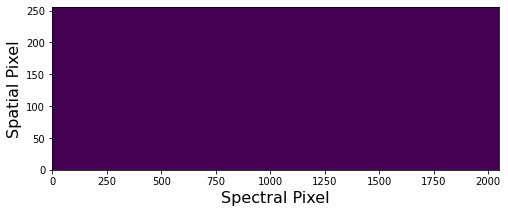

100%|███████████████████████████████████████████████████████████| 2048/2048 [00:47<00:00, 43.55it/s]


   0.17% of pixels interpolated.


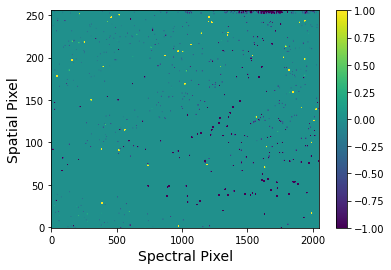

In [2]:
# Open a simulated data set.
#clear = fits.getdata('Ref_files/simulated_data.fits', 0)

padding = 20
oversampling = 1

if False:
    clear = fits.getdata('/Users/albert/NIRISS/Commissioning/analysis/SOSSfluxcal/stack_flux.fits')
    maskcont = fits.getdata('/Users/albert/NIRISS/Commissioning/analysis/SOSSfluxcal/mask_contamination.fits')
    output_filename = '/Users/albert/NIRISS/Commissioning/analysis/SOSSfluxcal/michael_trace/applesoss_traceprofile.fits'
    outdir = '/Users/albert/NIRISS/Commissioning/analysis/SOSSfluxcal/michael_trace/'
    xlim_order3= 1100

if False:
    clear = fits.getdata('/Users/albert/NIRISS/Commissioning/analysis/SOSSwavecal/stack_nis18_obs2.fits')
    maskcont = fits.getdata('/Users/albert/NIRISS/Commissioning/analysis/SOSSwavecal/mask_contamination.fits')
    output_filename = '/Users/albert/NIRISS/Commissioning/analysis/SOSSwavecal/michael_trace/applesoss_traceprofile.fits'
    outdir = '/Users/albert/NIRISS/Commissioning/analysis/SOSSwavecal/michael_trace/'
    xlim_order3 = 700

if True:
    clear = fits.getdata('/Users/albert/NIRISS/Commissioning/analysis/HATP14b/stack_hatp14.fits')
    #maskcont = fits.getdata('/Users/albert/NIRISS/Commissioning/analysis/HATP14b/mask_contamination.fits')
    maskcont = np.zeros((256,2048))
    output_filename = '/Users/albert/NIRISS/Commissioning/analysis/HATP14b/michael_trace/applesoss_traceprofile.fits'
    outdir = '/Users/albert/NIRISS/Commissioning/analysis/HATP14b/michael_trace/'
    xlim_order3 = 1100
    
maskcont = maskcont >=1


fig = plt.figure(figsize=(8, 3), facecolor='white')
plt.imshow(maskcont, origin='lower', aspect='auto')
plt.xlabel('Spectral Pixel', fontsize=16)
plt.ylabel('Spatial Pixel', fontsize=16)
plt.ylim(0, 256)
plt.show()


# Add a floor level so that all pixels are positive.
floor = np.nanpercentile(clear, 0.1)
clear -= floor

# Replace bad pixels.
clear = replace_badpix(clear, verbose=3)
#clear += floor

Data dimensions:
dimx=2048, dimy=256, xos=1, yos=1, xnative=2048, ynative=256


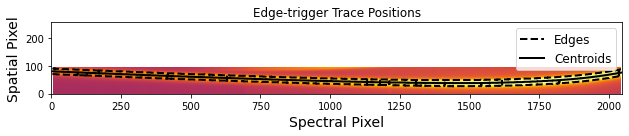

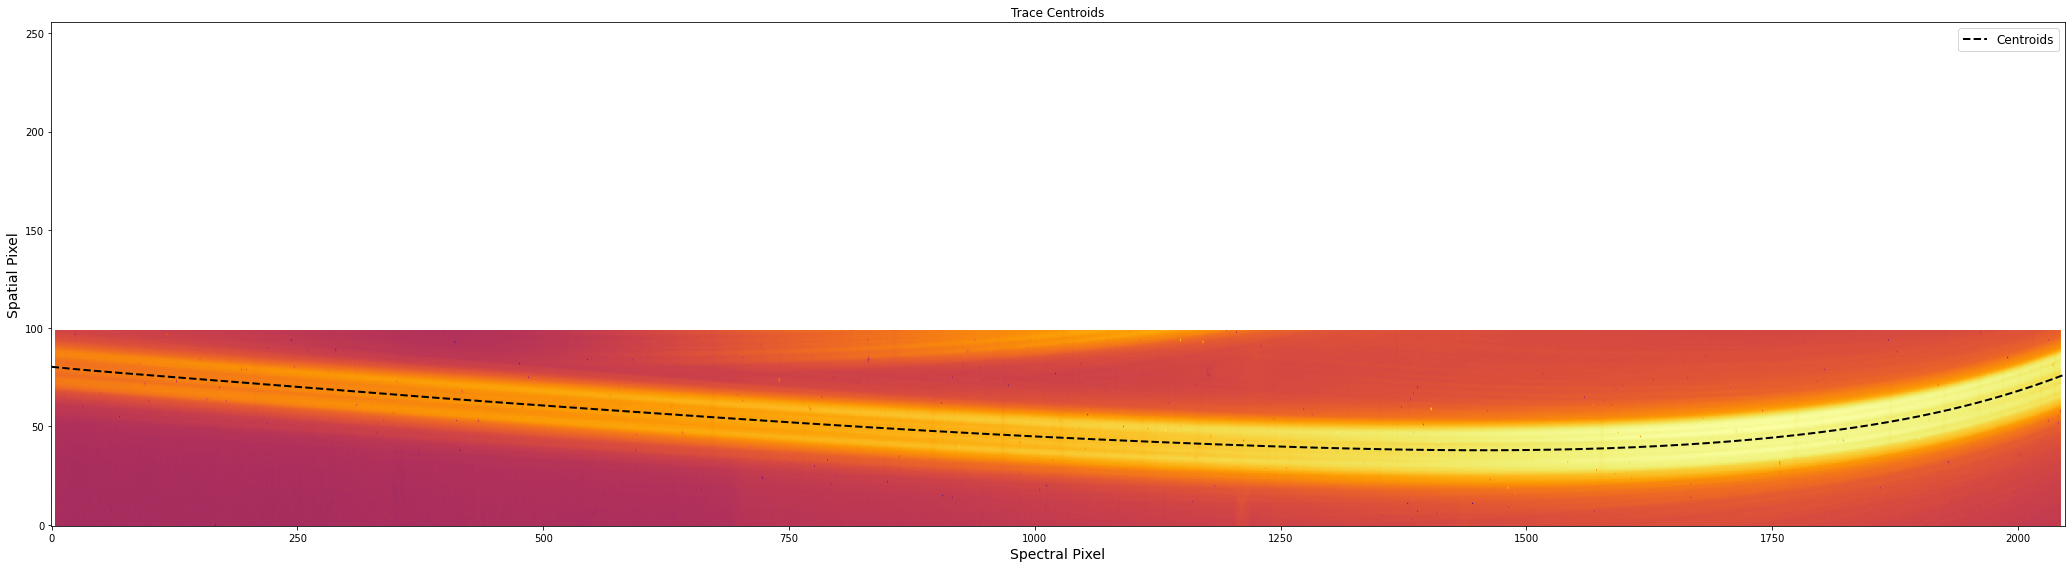

Data dimensions:
dimx=2048, dimy=256, xos=1, yos=1, xnative=2048, ynative=256


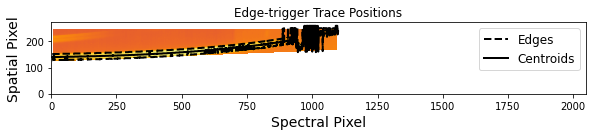

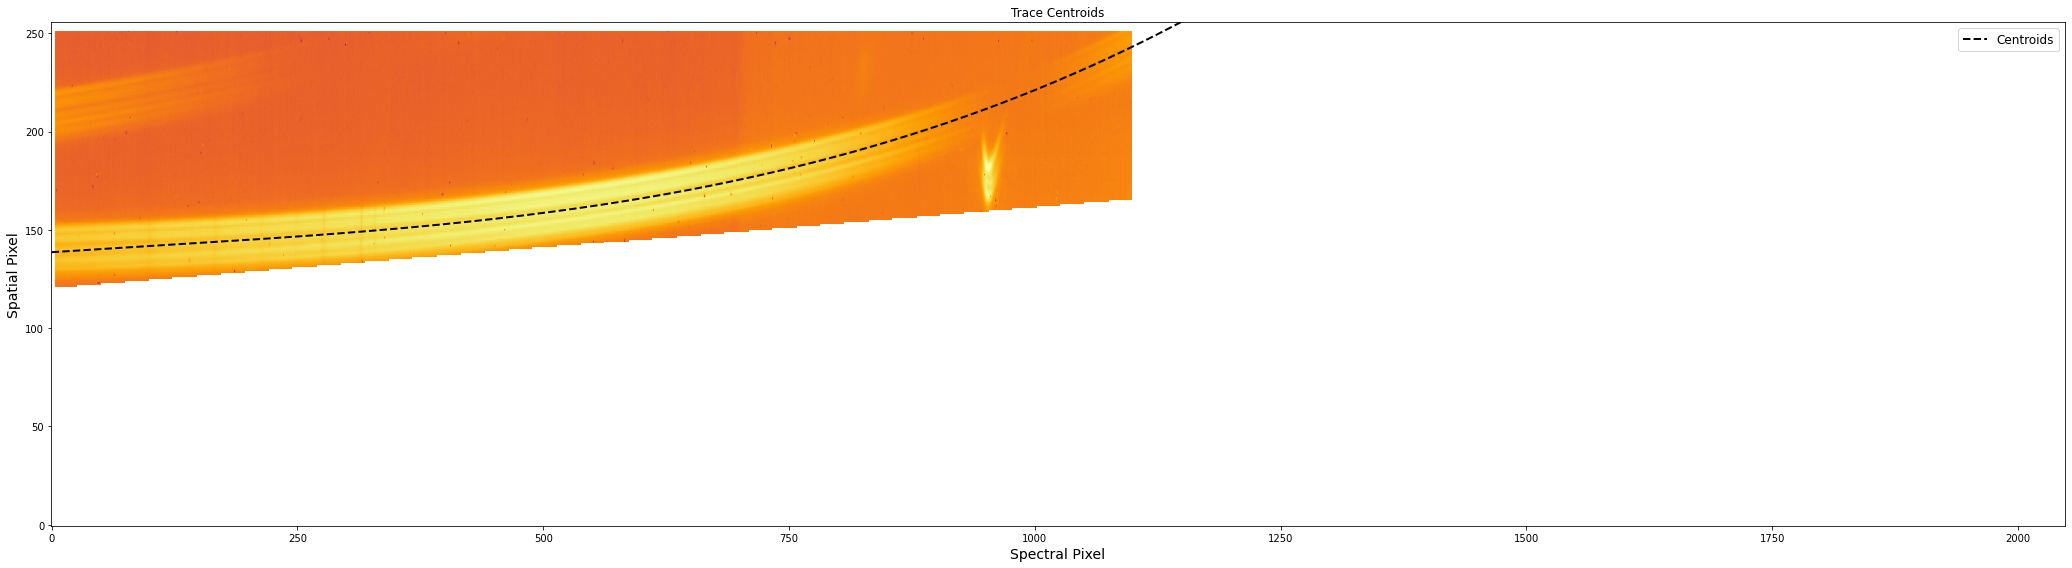

Data dimensions:
dimx=2048, dimy=256, xos=1, yos=1, xnative=2048, ynative=256


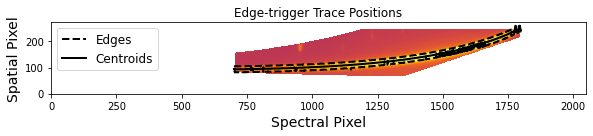

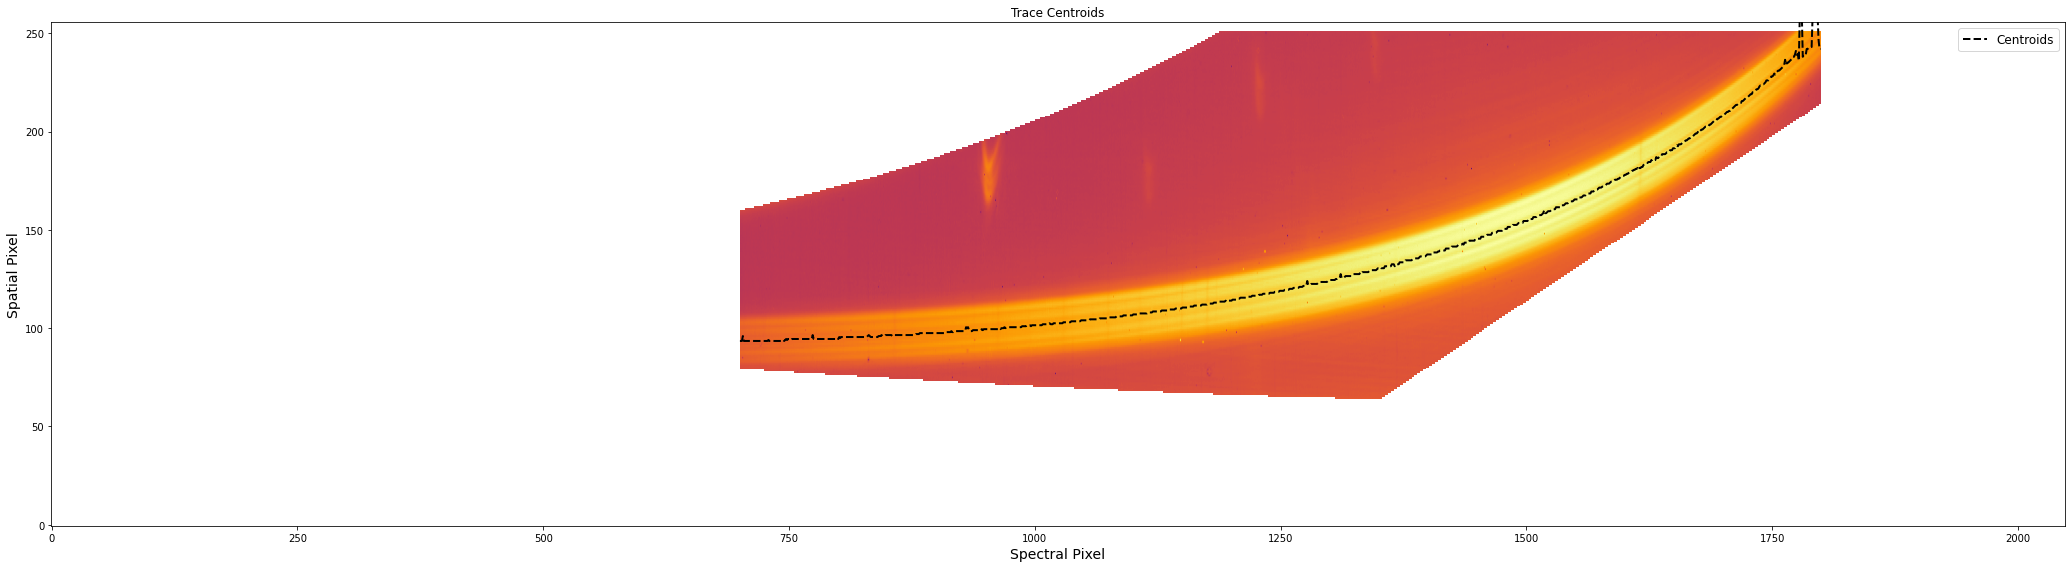

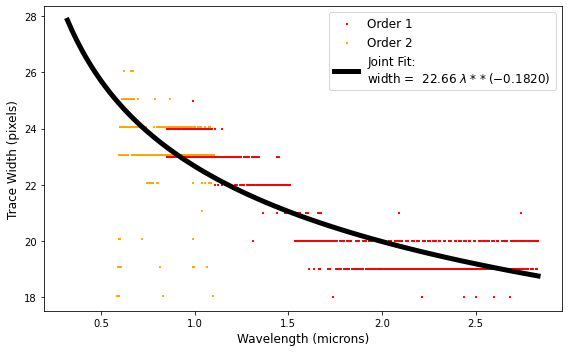

Data dimensions:
dimx=2048, dimy=256, xos=1, yos=1, xnative=2048, ynative=256


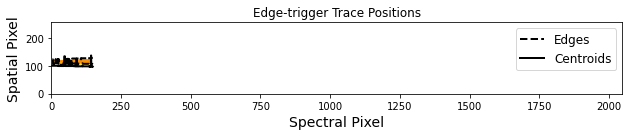

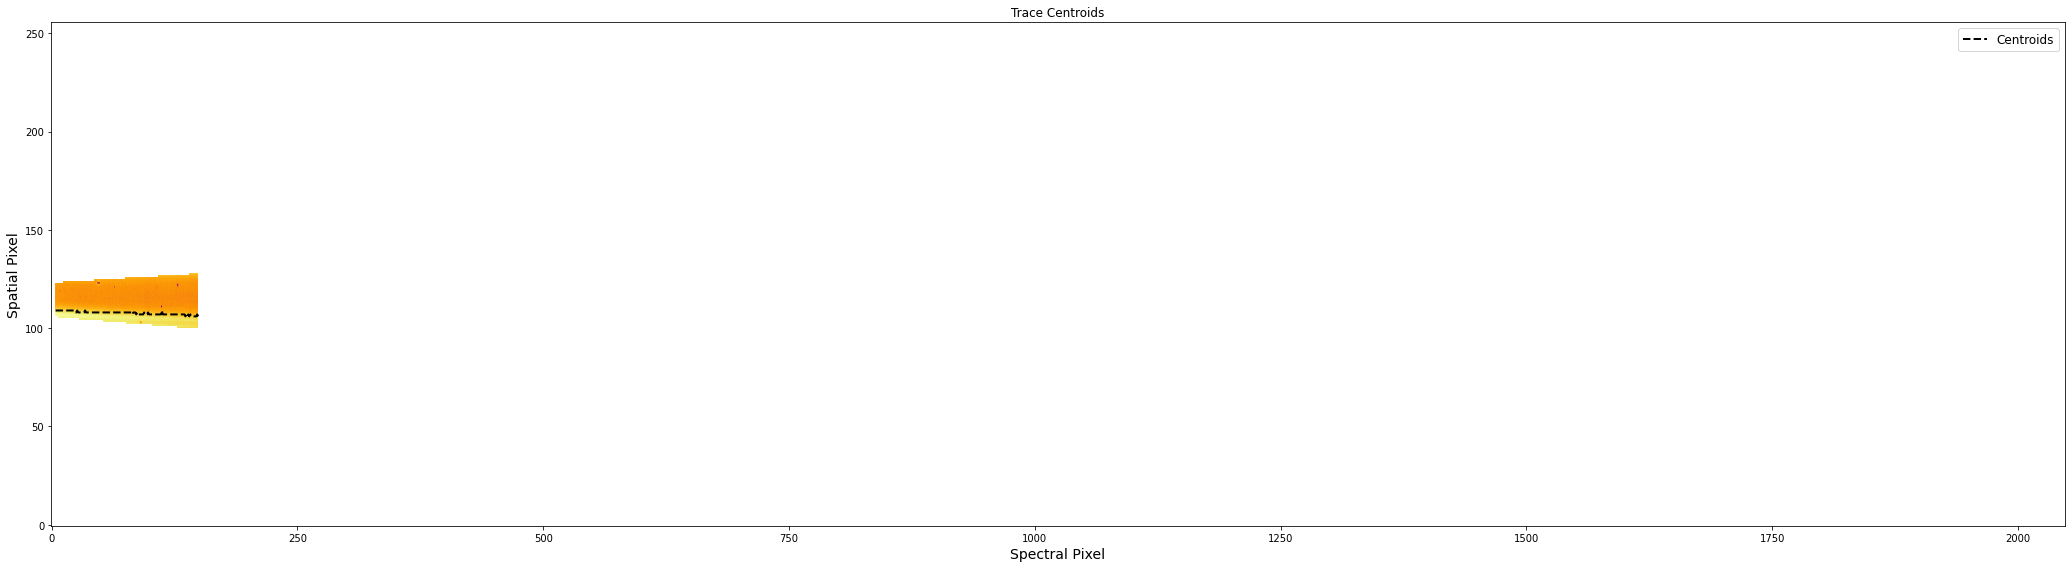

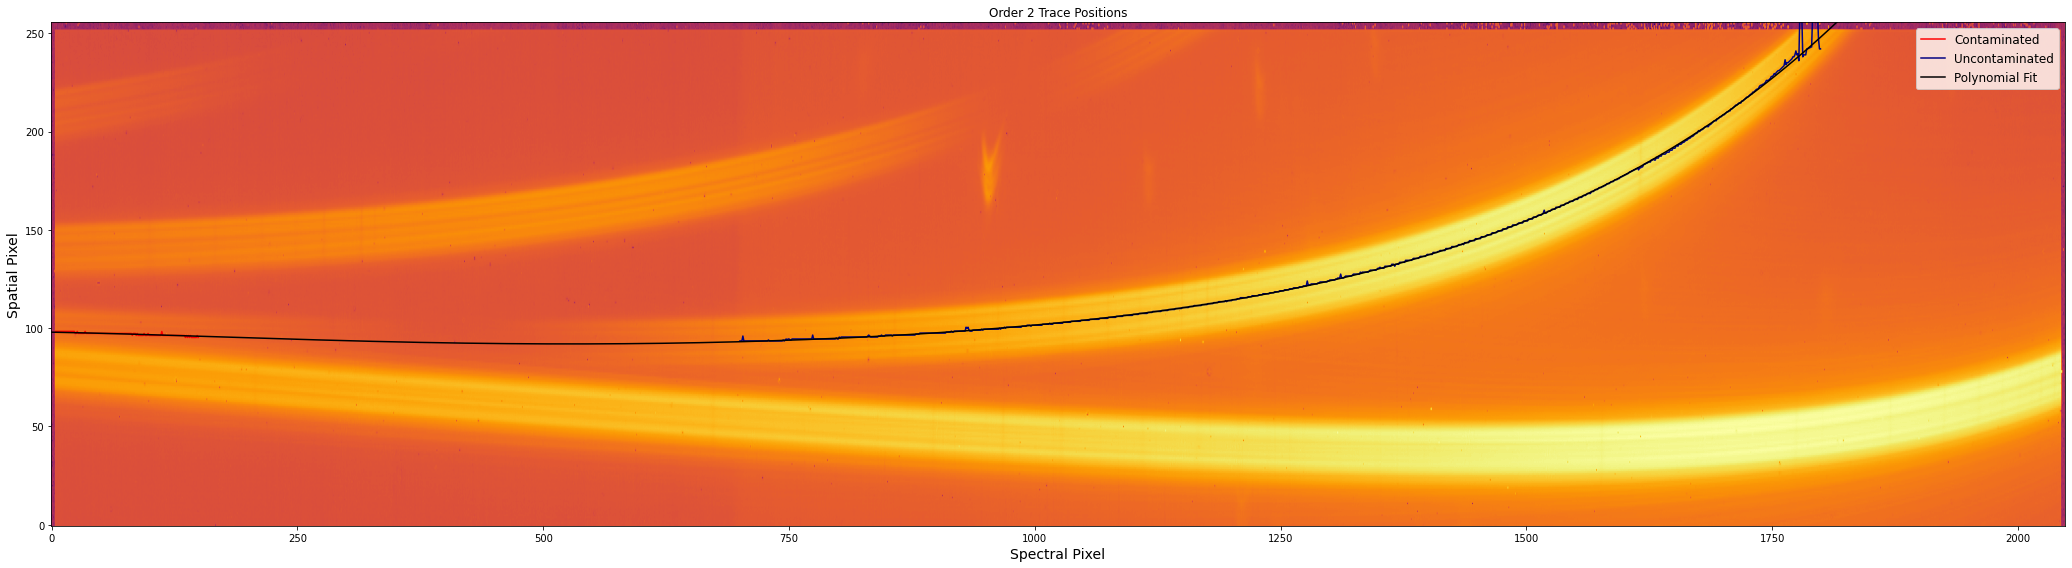

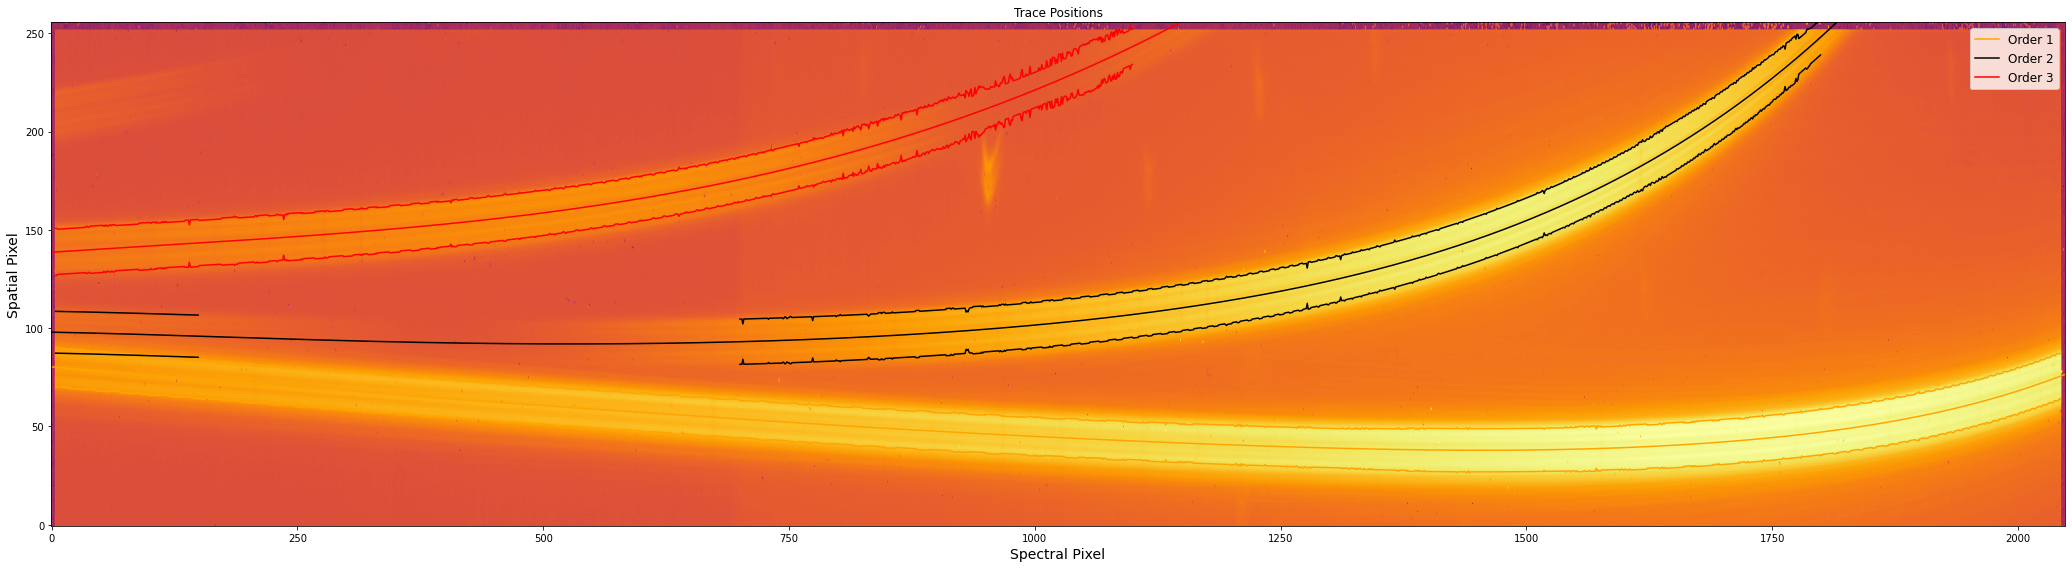

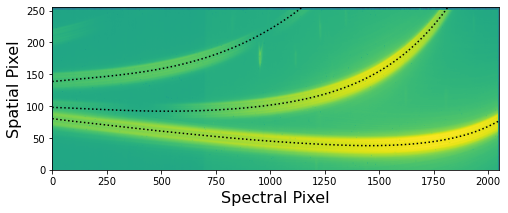

In [3]:
# Get the trace centroids for all three orders.
cen = get_soss_centroids(clear, subarray='SUBSTRIP256', mask=maskcont, 
                         outdir='/Users/albert/Downloads/', verbose=True, xlim_order3=xlim_order3)


# Plot the data frames
fig = plt.figure(figsize=(8, 3), facecolor='white')
plt.imshow(np.log10(clear), origin='lower', aspect='auto')
plt.plot(cen['order 1']['X centroid'], cen['order 1']['Y centroid'], ls=':', c='black')
plt.plot(cen['order 2']['X centroid'], cen['order 2']['Y centroid'], ls=':', c='black')
plt.plot(cen['order 3']['X centroid'], cen['order 3']['Y centroid'], ls=':', c='black')

plt.xlabel('Spectral Pixel', fontsize=16)
plt.ylabel('Spatial Pixel', fontsize=16)
plt.ylim(0, 256)
plt.show()

# Add back the floor level
clear += floor

In [4]:
# Save the centroids to file
ascii.write({'x': cen['order 1']['X centroid'], 'y': cen['order 1']['Y centroid']}, 
            outdir+'xy_order1.txt', formats={'x': '%.2f', 'y': '%.2f'})
ascii.write({'x': cen['order 2']['X centroid'], 'y': cen['order 2']['Y centroid']}, 
            outdir+'xy_order2.txt', formats={'x': '%.2f', 'y': '%.2f'})
ascii.write({'x': cen['order 3']['X centroid'], 'y': cen['order 3']['Y centroid']}, 
            outdir+'xy_order3.txt', formats={'x': '%.2f', 'y': '%.2f'})


The ```EmpiricalProfile``` class of APPleSOSS is the workhorse of this module. To initialize it, it requires a CLEAR exposure data frame. Optional arguments are the amount of padding to add around the edges of the frames, as well as the factor of oversampling.  

Call ```build_empirical_profile``` once the class is initialized to reconstruct the spatial profiles for the first, second, and third orders. 

Afterwards, the ```write_specprofile_reference``` method can be called to save the profiles to an external file for use as the specprofile reference file needed by the ATOCA algorithm.

In [5]:
spat_prof = applesoss.EmpiricalProfile(clear, pad=padding, oversample=oversampling)
spat_prof.build_empirical_profile(verbose=1, wave_increment=0.1)

Starting the APPLESOSS module.

 Initial processing.
  Interpolating bad pixels...
   0.11% of pixels interpolated.
  Getting trace centroids...
  Generating 23 PSFs... Expected to take about 1 min(s).
 Building the spatial profile models.
  Starting the first order model...
  Starting the second order trace...
  Starting the third order trace...
 Adding padding to the spectral axis...

Done.


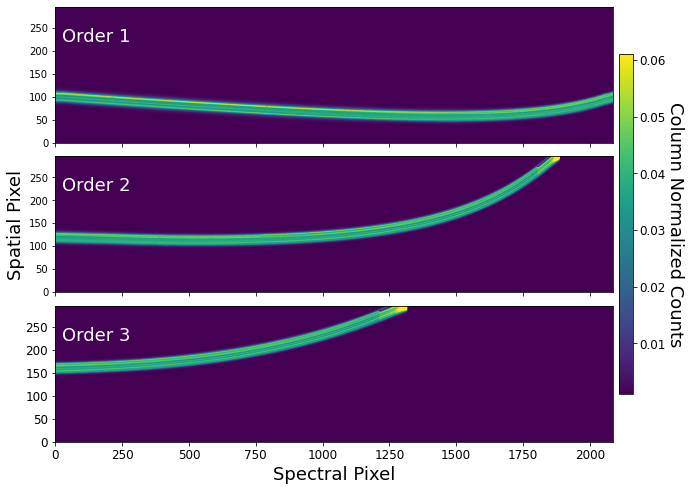

In [6]:
# Show the spatial profile models for each order.
fig, ax = plt.subplots(3, figsize=(10, 8), facecolor='white')

ax1 = ax[0]
ax1.imshow(spat_prof.order1, origin='lower', aspect='auto', vmax=0.061, vmin=0.001)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
plt.yticks(fontsize=12)
ax1.text(25, 220, 'Order 1', fontsize=18, c='white')

ax2 = ax[1]
aa = ax2.imshow(spat_prof.order2, origin='lower', aspect='auto', vmin=0.001, vmax=0.061)
cax = ax2.inset_axes([1.01, -0.75, 0.025, 2.5], transform=ax2.transAxes)
cbar = plt.colorbar(aa, ax=ax[:], cax=cax)
cbar.set_label(r'Column Normalized Counts', rotation=270, fontsize=18, labelpad=18)
cbar.ax.tick_params(labelsize=12)

ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.set_ylabel('Spatial Pixel', fontsize=18)
plt.yticks(fontsize=12)
ax2.text(25, 220, 'Order 2', fontsize=18, c='white')

ax3 = ax[2]
ax3.imshow(spat_prof.order3, origin='lower', aspect='auto', vmin=0.001, vmax=0.061)
ax3.set_xlabel('Spectral Pixel', fontsize=18)
ax3.text(25, 220, 'Order 3', fontsize=18, c='white')

plt.subplots_adjust(hspace=0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
# Create a SUBSTRIP256 spatial profile reference file
spat_prof.write_specprofile_reference('SUBSTRIP256', filename=output_filename)

Saving to file /Users/albert/NIRISS/Commissioning/analysis/HATP14b/michael_trace/applesoss_traceprofile.fits


In [8]:
# Open the true spatial profiles which were seeded in the simulation and bin down to 
# native resolution.
ref = fits.open('/Users/michaelradica/transfer/ref_profile_realization0.fits')

array = ref[1].data[40:-40, 40:-40]
shape = np.shape(array)
binned_array = array.reshape(256, 4, 2048, 4)
mod_1 = binned_array.mean(-1).sum(1)

array = ref[2].data[40:-40, 40:-40]
shape = np.shape(array)
binned_array = array.reshape(256, 4, 2048, 4)
mod_2 = binned_array.mean(-1).sum(1)

array = ref[3].data[40:-40, 40:-40]
shape = np.shape(array)
binned_array = array.reshape(256, 4, 2048, 4)
mod_3 = binned_array.mean(-1).sum(1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michaelradica/transfer/ref_profile_realization0.fits'

In [ ]:
# Compare the APPLESOSS profiles to the reference profiles.
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(spat_prof.order1 - mod_1, origin='lower', aspect='auto', vmin=-1e-2, vmax=1e-2)
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(spat_prof.order2 - mod_2, origin='lower', aspect='auto', vmin=-1e-2, vmax=1e-2)
plt.colorbar()
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.set_ylabel('Spatial Pixel', fontsize=18)
plt.yticks(fontsize=12)

ax3 = ax[2]
ax3.imshow(spat_prof.order3 - ref_o3, origin='lower', aspect='auto', vmin=-1e-3, vmax=1e-3)
ax3.set_xlabel('Spectral Pixel', fontsize=18)
rms = np.sqrt(np.nanmean((spat_prof.order3 - ref_o3)**2))
ax3.text(10, 230, 'RMS = {:.2e}'.format(rms), fontsize=12)

plt.subplots_adjust(hspace=0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Create a SUBSTRIP256 spatial profile reference file
spat_prof.write_specprofile_reference('SUBSTRIP256')